# Selection de variables avec le lasso

In [44]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import matplotlib.pyplot as plt
import pprint
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [45]:
from sklearn import svm
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [46]:
from sklearn.linear_model import Lasso
#voir si besoin de standardiser les features


In [123]:
#importation des donnees
url_retards ='https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC'
retards = requests.get(url_retards)
wb_retards = retards.json()

df_retards = pd.DataFrame(wb_retards)
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,32,5.363539,9,4,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,None,193,7.294991,...,56,7.225734,29,11,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333


In [124]:
#on retire les colonnes de commentaires qui sont generalement vides
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)

In [125]:
#on retire aussi les colonnes de NaN et dont les retards valent 0 qui ne nous interessent pas ici
df_retards.dropna(inplace = True)
df_retards = df_retards.drop(df_retards[df_retards['nb_train_retard_arrivee']==0].index)

In [126]:
df_retards['cause_materiel_roulant'] = df_retards['prct_cause_materiel_roulant']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_infra'] = df_retards['prct_cause_infra']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_gestion_trafic'] = df_retards['prct_cause_gestion_trafic']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_externe'] = df_retards['prct_cause_externe']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_gestion_gare'] = df_retards['prct_cause_gestion_gare']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_prise_en_charge_voyageurs'] = df_retards['prct_cause_prise_en_charge_voyageurs']/100*df_retards['nb_train_retard_arrivee']
df_retards

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,16.666667,16.666667,8.333333,3.333333,17.500000,36.750000,17.500000,21.000000,8.750000,3.500000
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,193,7.294991,2.720211,...,21.333333,4.000000,9.333333,1.333333,3.360000,22.400000,17.920000,31.360000,7.840000,1.120000
2,2018-01,National,PARIS MONTPARNASSE,ANGERS SAINT LAUD,90,385,3,49,8.362585,0.730105,...,21.428571,23.809524,9.523810,0.000000,12.380952,12.380952,11.142857,11.142857,4.952381,0.000000
3,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,1.003981,...,15.384615,19.230769,0.000000,0.000000,5.000000,10.000000,4.000000,7.000000,0.000000,0.000000
4,2018-01,National,POITIERS,PARIS MONTPARNASSE,94,472,4,224,6.784673,3.229701,...,19.298246,15.789474,1.754386,1.754386,14.052632,40.596491,17.175439,14.052632,1.561404,1.561404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,2022-08,National,PARIS MONTPARNASSE,NANTES,130,584,5,68,15.297059,1.453080,...,15.909091,22.727273,2.272727,15.909091,10.227273,1.022727,7.159091,18.409091,1.022727,7.159091
6933,2022-08,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,62,509,0,53,10.325786,0.677472,...,26.530612,42.857143,6.122449,12.244898,23.142857,5.510204,14.326531,1.102041,3.306122,6.612245
6934,2022-08,National,PARIS MONTPARNASSE,TOURS,74,167,0,16,12.529167,0.835529,...,16.666667,50.000000,8.333333,16.666667,7.500000,1.250000,2.500000,0.000000,1.250000,2.500000
6935,2022-08,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,169,119,0,34,4.072549,1.626754,...,28.571429,23.809524,0.000000,9.523810,5.000000,2.000000,6.000000,6.000000,0.000000,2.000000


In [127]:
#on copie la dataframe initiale par securite
df_retards_initial = df_retards.copy()
#df_retards = df_retards_initial.copy()
df_retards

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,16.666667,16.666667,8.333333,3.333333,17.500000,36.750000,17.500000,21.000000,8.750000,3.500000
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,193,7.294991,2.720211,...,21.333333,4.000000,9.333333,1.333333,3.360000,22.400000,17.920000,31.360000,7.840000,1.120000
2,2018-01,National,PARIS MONTPARNASSE,ANGERS SAINT LAUD,90,385,3,49,8.362585,0.730105,...,21.428571,23.809524,9.523810,0.000000,12.380952,12.380952,11.142857,11.142857,4.952381,0.000000
3,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,1.003981,...,15.384615,19.230769,0.000000,0.000000,5.000000,10.000000,4.000000,7.000000,0.000000,0.000000
4,2018-01,National,POITIERS,PARIS MONTPARNASSE,94,472,4,224,6.784673,3.229701,...,19.298246,15.789474,1.754386,1.754386,14.052632,40.596491,17.175439,14.052632,1.561404,1.561404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,2022-08,National,PARIS MONTPARNASSE,NANTES,130,584,5,68,15.297059,1.453080,...,15.909091,22.727273,2.272727,15.909091,10.227273,1.022727,7.159091,18.409091,1.022727,7.159091
6933,2022-08,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,62,509,0,53,10.325786,0.677472,...,26.530612,42.857143,6.122449,12.244898,23.142857,5.510204,14.326531,1.102041,3.306122,6.612245
6934,2022-08,National,PARIS MONTPARNASSE,TOURS,74,167,0,16,12.529167,0.835529,...,16.666667,50.000000,8.333333,16.666667,7.500000,1.250000,2.500000,0.000000,1.250000,2.500000
6935,2022-08,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,169,119,0,34,4.072549,1.626754,...,28.571429,23.809524,0.000000,9.523810,5.000000,2.000000,6.000000,6.000000,0.000000,2.000000


In [128]:
causes_retards = ['cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs']
causes_retards_large = ['nb_annulation', 'nb_train_prevu', 'duree_moyenne', 'cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs']

In [129]:
x = sm.add_constant(df_retards[causes_retards])
y = df_retards[['nb_train_retard_arrivee']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)
xTest

,const,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
4276,1.0,4.000000,3.000000,0.000000,5.000000,0.000000,7.000000
1422,1.0,9.346154,3.115385,7.269231,6.230769,0.000000,1.038462
3908,1.0,7.000000,10.000000,1.000000,2.000000,3.000000,2.000000
1989,1.0,5.000000,8.000000,4.000000,6.000000,8.000000,4.000000
1105,1.0,4.163265,16.653061,19.775510,10.408163,0.000000,0.000000
...,...,...,...,...,...,...,...
2114,1.0,3.000000,6.000000,7.000000,5.000000,4.000000,1.000000
1916,1.0,9.000000,6.000000,4.000000,6.000000,2.000000,0.000000
2965,1.0,2.090909,4.181818,6.272727,8.363636,0.000000,2.090909
6716,1.0,10.606061,1.060606,7.424242,12.727273,2.121212,1.060606


In [130]:
#on fait la regression lineaire

results = sm.OLS(yTrain, xTrain).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 5.536e+04
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:11:52   Log-Likelihood:                -14894.
No. Observations:                5424   AIC:                         2.980e+04
Df Residuals:                    5417   BIC:                         2.985e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [131]:
#puis on predit les resultats
#yPred = sm.predict(xTrain)
yPred = results.predict(xTest)
epsilon = yTest - yPred

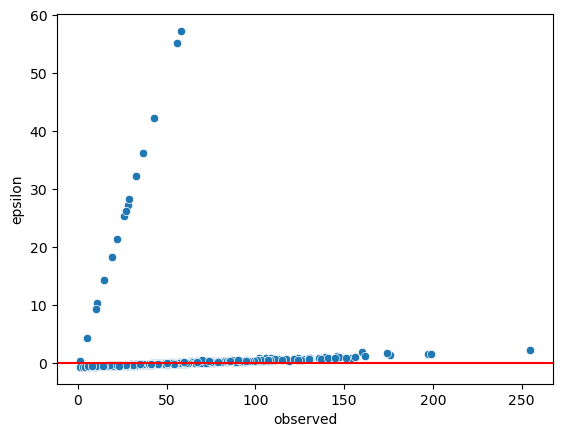

In [132]:
#Nuage de points des valeurs observées
tempdf = pd.DataFrame({"prediction": yPred, "observed": yTest,
                       "epsilon": yTest - yPred})

fig = plt.figure()
g = sns.scatterplot(data = tempdf, x = "observed", y = "epsilon")
g.axhline(0, color = "red")

In [133]:
df_retards = df_retards_initial.copy()
x = sm.add_constant(df_retards[causes_retards_large])
y = df_retards[['nb_train_retard_arrivee']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)
xTest

,const,nb_annulation,nb_train_prevu,duree_moyenne,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
923,1.0,58,218,301,1.766667,15.900000,7.066667,26.500000,0.000000,1.766667
4154,1.0,0,472,168,14.000000,9.000000,6.000000,15.000000,6.000000,11.000000
1671,1.0,0,230,191,1.117647,4.470588,2.235294,11.176471,0.000000,0.000000
4704,1.0,0,351,159,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
1984,1.0,10,235,155,8.461538,23.269231,10.576923,11.634615,1.057692,0.000000
...,...,...,...,...,...,...,...,...,...,...
5288,1.0,7,297,97,11.000000,6.000000,7.000000,3.000000,2.000000,3.000000
94,1.0,4,279,189,10.421053,6.947368,6.947368,17.368421,2.315789,0.000000
3334,1.0,8,54,357,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000
426,1.0,66,227,100,7.885714,5.257143,15.771429,11.828571,3.942857,1.314286


In [134]:
#3. Estimer un modèle LASSO et afficher les valeurs des coefficients
lasso1 = Lasso(fit_intercept=True,normalize=False, alpha = 0.1).fit(xTrain,yTrain)

#np.abs(lasso1.coef_)
features_selec = x.columns[np.abs(lasso1.coef_)>0].tolist()
features_selec 

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


['nb_annulation',
 'nb_train_prevu',
 'duree_moyenne',
 'cause_materiel_roulant',
 'cause_infra',
 'cause_gestion_trafic',
 'cause_externe',
 'cause_gestion_gare',
 'cause_prise_en_charge_voyageurs']

In [135]:
#4. Corrélations entre les variables sélectionnées
corr = df_retards[features_selec].corr()

plt.figure()
p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
p

/tmp/ipykernel_291/3579470952.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,nb_annulation,nb_train_prevu,duree_moyenne,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
nb_annulation,1.00,0.23,-0.13,0.05,0.12,0.02,0.14,0.03,-0.02
nb_train_prevu,0.23,1.00,-0.44,0.61,0.56,0.48,0.53,0.52,0.50
duree_moyenne,-0.13,-0.44,1.00,-0.27,-0.28,-0.29,-0.16,-0.29,-0.20
cause_materiel_roulant,0.05,0.61,-0.27,1.00,0.47,0.53,0.44,0.53,0.36
cause_infra,0.12,0.56,-0.28,0.47,1.00,0.57,0.50,0.42,0.31
cause_gestion_trafic,0.02,0.48,-0.29,0.53,0.57,1.00,0.46,0.49,0.36
cause_externe,0.14,0.53,-0.16,0.44,0.50,0.46,1.00,0.35,0.27
cause_gestion_gare,0.03,0.52,-0.29,0.53,0.42,0.49,0.35,1.00,0.46
cause_prise_en_charge_voyageurs,-0.02,0.50,-0.20,0.36,0.31,0.36,0.27,0.46,1.00


<Figure size 640x480 with 0 Axes>

In [136]:
#5. Faire une régression linéaire parcimonieuse et non parcimonieuse

## Régression parcimonieuse
yPred_parci = lasso1.predict(xTest)
rmse_parci = sklearn.metrics.mean_squared_error(yTest, yPred_parci, squared = False)
print("rmse_parci : ", rmse_parci)
rsq_parci = sklearn.metrics.r2_score(yTest, yPred_parci) 
print("rsq_parci : ", rsq_parci)

## Régression non parcimonieuse
ols = LinearRegression().fit(xTrain, yTrain)
yPred_nonparci = ols.predict(xTest)
rmse_nonparci = sklearn.metrics.mean_squared_error(yTest, yPred_nonparci, squared = False)
print("rmse_nonparci : ", rmse_nonparci)
rsq_nonparci = sklearn.metrics.r2_score(yTest, yPred_nonparci) 
print("rsq_nonparci : ", rsq_nonparci)

# Le modèle parcimonieux est (légèrement) plus performant. 

rmse_parci :  2.4916856397018203
rsq_parci :  0.9930000375505456
rmse_nonparci :  2.489941269561103
rsq_nonparci :  0.9930098351358738
